# Hierachisches Cluster zur Zusammenhangsanalyse

In [7]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as ss
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta

np.seterr(all='raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

## Hilfsfunktionen

In [8]:
  def PandasDatetimeToFloat64(x):
    return (x - x.min()) / pd.offsets.Second(1)

## Datenaufbereitung

In [9]:
df = pd.read_csv('/data/DEvideos.csv',
    low_memory=False)

df['trending_date'] = df.apply(lambda row: datetime.strptime(row['trending_date'], '%y.%d.%m'), axis=1)
df['publish_time'] = df.apply(lambda row: datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z'), axis=1)
df['days_until_trending'] = df.apply(lambda row: ((row['trending_date'] - row['publish_time']).days + 1), axis=1)

N = len(df)
dropColumns = ['video_id', 'title', 'tags', 'thumbnail_link', 'description']
for column in df.columns:
    numberOfUniqueValues = df[column].nunique()
    if numberOfUniqueValues < 2:
        dropColumns.append(column)
    elif df[column].dtype == 'object' and numberOfUniqueValues > N * 0.9:
        dropColumns.append(column)
    elif df[column].isna().sum() / N > 0.95:
        dropColumns.append(column)
        
df.drop(columns=dropColumns, inplace=True)
df['channel_title'] = df['channel_title'].astype('category')

In [10]:
def crosstab(x, y):
    """ efficient variant of pandas.crosstab for two series."""
    # Drop unused categories
    x = x.cat.remove_unused_categories() 
    y = y.cat.remove_unused_categories()
    
    # Calculate counts of unique elements
    tmp = np.column_stack((x.cat.codes, y.cat.codes))
    loc, count = np.unique(tmp, axis=0, return_counts=True)
    
    # Expand (unstack) counts into pivot table
    xtab = np.zeros((max(x.cat.codes)+1, max(y.cat.codes)+1))
    xtab[loc[:, 0], loc[:, 1]] = count    
    return xtab

def cramers_corrected_V(x, y):    
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = crosstab(x, y)   
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def feature_distance(x, y):
    if x.nunique() < 2 or y.nunique() < 2:
        return 1.0
    
    xdt, ydt = x.dtype.name, y.dtype.name    
    
    # Convert bool to category
    if xdt == 'bool':
        x = x.astype('category')
        xdt = 'category'
    if ydt == 'bool':
        y = y.astype('category')
        ydt = 'category'
    
    # If only one feature is a category, make sure x is that feature
    if xdt != 'category' and ydt == 'category':
        x, y = y, x
        xdt, ydt = ydt, xdt
    
    # print(f"{x.name}({xdt}), {y.name}({ydt})")
    if xdt == 'category':
        if ydt == 'category':
            if x.dtype.ordered and y.dtype.ordered:
                r, _ = ss.spearmanr(x, y)
                return 1.0 - np.abs(r)
            else:
                return 1.0 - cramers_corrected_V(x, y)        
        else:
            if len(x.dtype.categories) == 2:
                r, _ = ss.pointbiserialr(x == x.dtype.categories[0], y)
                return 1.0 - np.abs(r)
            elif x.dtype.ordered:
                r, _ = ss.spearmanr(x, y)
                return 1.0 - np.abs(r)
            else:            
                # FIXME: No ideal measure of "distance"!
                return 1.0            
    else:
        r, _ = ss.pearsonr(x, y)
        return 1.0 - np.abs(r)
    
def pairwise_feature_distance(df):
    """
    Calculate all pairwise feature distances for ``df``.
    
    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------    
    D : ndarray
        A condensed distance matrix
    """
    df = df.copy()
    # Convert datetime to floats
    for column in df.columns:
        if df[column].dtype.name == 'datetime64[ns]':
            df[column] = PandasDatetimeToFloat64(df[column])
  
    m = len(df.columns)
    D = np.empty((m * (m - 1)) // 2, dtype=np.double)
    k = 0

    print('Berechnung...')
    for i in range(0, m - 1):
        print('.', end='') # loading bar
    print('')

    # For every pair of features (columns):
    for i in range(0, m - 1):    
        print('.', end='') # loading bar
        for j in range(i + 1, m):
            # Remove any NA/NaNs.
            subset = df.iloc[:, [i, j]].dropna()        
            A = subset.iloc[:, 0]
            B = subset.iloc[:, 1]
            # Calculate distance            
            D[k] = feature_distance(A, B)
            k = k + 1
    print('')
    return D    

In [11]:
%%time
D = pairwise_feature_distance(df)

Berechnung...
...........
...........
CPU times: user 901 ms, sys: 8.45 s, total: 9.35 s
Wall time: 677 ms


In [12]:
D

array([1.        , 0.99918631, 0.04621774, 0.96607735, 0.97601037,
       0.9987038 , 0.98543342, 0.9730282 , 0.98869421, 0.99432388,
       0.98793146, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.15103174, 0.15438161, 0.32428908,
       1.        , 0.99639039, 0.91111085, 0.90208826, 0.98871438,
       0.95677381, 0.9897224 , 0.97838661, 0.97309679, 0.98563909,
       0.96994264, 0.97833384, 0.99956991, 0.98674952, 0.97517392,
       0.98982832, 0.99470666, 0.68802972, 0.17581132, 0.44399993,
       0.29448403, 0.99709917, 0.9972073 , 0.99617492, 0.99341495,
       0.53979232, 0.14750763, 0.97195102, 0.97220542, 0.99748028,
       0.99676022, 0.3578565 , 0.98870504, 0.98760322, 0.99959196,
       0.99746604, 0.97415365, 0.9856087 , 0.99985536, 0.99828614,
       0.74111249, 1.        , 0.99771624, 1.        , 0.99771949,
       0.99965659])

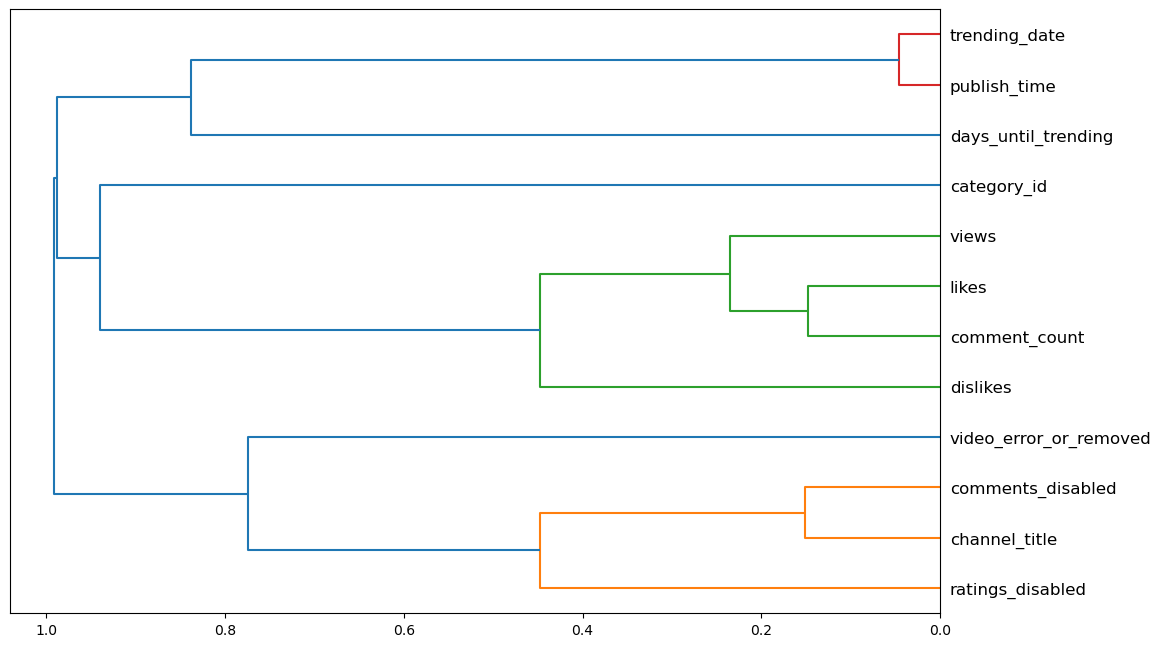

In [13]:
Z = hc.linkage(D, method='average', optimal_ordering=True)
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ddg = hc.dendrogram(Z, labels=df.columns, orientation='left')

<AxesSubplot:>

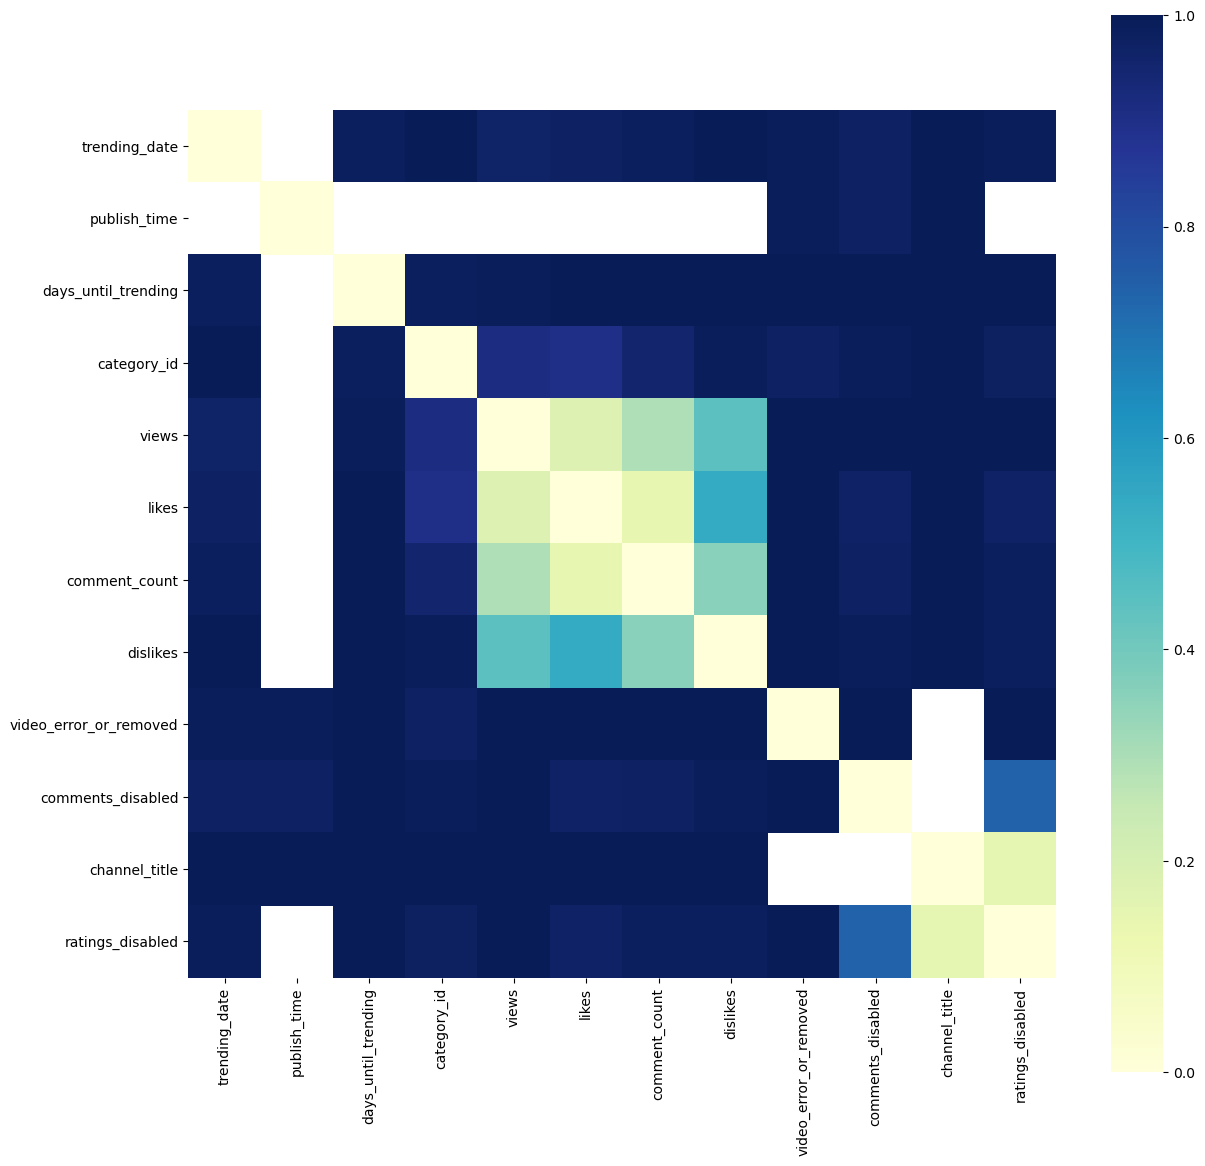

In [14]:
fig=plt.figure(figsize=(14,14), dpi= 100)
M = sp.spatial.distance.squareform(D)
o = np.flip(hc.leaves_list(Z))
M = M[:, o][o, :]
sns.heatmap(M,
            xticklabels=df.columns[o], 
            yticklabels=df.columns[o], 
            square=True,
            mask=sp.spatial.distance.squareform(D)>=1.0,
            cmap='YlGnBu')